In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb



from sklearn.model_selection import train_test_split #splitting data
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # scoring
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


In [3]:

#Clean Data

def clean_data( file):
    raw = pd.read_csv(file)

    #Unnecessary features
    del raw['Cabin']
    del raw['Ticket']
    del raw['Name']

    Id_holder = raw['PassengerId'] 
    del raw['PassengerId']

    raw = raw.fillna(0)



    #on-hot enconde all features that are categorical


    raw['Parch_0'] = raw['Parch'].replace([0,1,2],[1,0,0])
    raw['Parch_1'] = raw['Parch'].replace([0,1,2],[0,1,0])
    raw['Parch_2'] = raw['Parch'].replace([0,1,2],[0,0,1])

    raw['Pclass_1'] = raw['Pclass'].replace([1,2,3],[1,0,0])
    raw['Pclass_2'] = raw['Pclass'].replace([1,2,3],[0,1,0])
    raw['Pclass_3'] = raw['Pclass'].replace([1,2,3],[0,0,1])

    raw['SibSp_0'] = raw['SibSp'].replace([0,1,2,3,4,5],[1,0,0,0,0,0])
    raw['SibSp_1'] = raw['SibSp'].replace([0,1,2,3,4,5],[0,1,0,0,0,0])
    raw['SibSp_2'] = raw['SibSp'].replace([0,1,2,3,4,5],[0,0,1,0,0,0])
    raw['SibSp_3'] = raw['SibSp'].replace([0,1,2,3,4,5],[0,0,0,1,0,0])
    raw['SibSp_4'] = raw['SibSp'].replace([0,1,2,3,4,5],[0,0,0,0,1,0])
    raw['SibSp_5'] = raw['SibSp'].replace([0,1,2,3,4,5],[0,0,0,0,0,1])
    
    del raw['SibSp']
    del raw['Parch']
    del raw['Pclass']

   
   
    #Set up inputs and outputs
    if 'Survived' in raw.columns:
        X = raw.drop('Survived',axis=1).copy()
        X_encoded = pd.get_dummies(X, columns=['Embarked','Sex'])
        cols = [c for c in X_encoded.columns if c.lower()[-2:] != '_0']  # after one hot enconding delete any column that may have been created due to the filled in 0s --> this is a case by case solution
        X_encoded = X_encoded[cols]
        y = raw['Survived'].copy()
        return X_encoded, y, Id_holder
    else:
        X_encoded = pd.get_dummies(raw, columns=['Embarked','Sex'])
        cols = [c for c in X_encoded.columns if c.lower()[-2:] != '_0']  # after one hot enconding delete any column that may have been created due to the filled in 0s --> this is a case by case solution
        X_encoded = X_encoded[cols]
        return X_encoded, Id_holder

X_encoded, y, Id_holder = clean_data('train.csv')



In [4]:
sum(y)/len(y)

0.3838383838383838

In [5]:
#BUILD LE TREE
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, random_state = 42, stratify = y)
X_train.shape

(668, 17)

In [6]:
#Check to see if both the train set and test set have the same percentage of people who survived
(sum(y_test)/len(y_test)) == (sum(y_train)/len(y_train))

False

In [7]:
#BUILD LE TREE
clf_xgb= xgb.XGBClassifier(objective ='binary:logistic',eval_metric ='aucpr', early_stopping_rounds=10, seed = 42)
clf_xgb.fit(X_train,
            y_train,
            verbose = True,            
            eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.81027
[1]	validation_0-aucpr:0.80636
[2]	validation_0-aucpr:0.81435
[3]	validation_0-aucpr:0.81330
[4]	validation_0-aucpr:0.83309
[5]	validation_0-aucpr:0.82848
[6]	validation_0-aucpr:0.82382
[7]	validation_0-aucpr:0.81987
[8]	validation_0-aucpr:0.81895
[9]	validation_0-aucpr:0.81375
[10]	validation_0-aucpr:0.81384
[11]	validation_0-aucpr:0.80046
[12]	validation_0-aucpr:0.80122
[13]	validation_0-aucpr:0.78438
[14]	validation_0-aucpr:0.78262


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

C:\Users\iseze\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


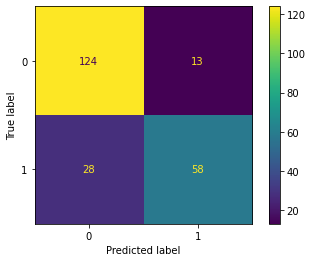

In [8]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format = 'd')

In [9]:
#Optimize: --> It needs to be optimized-- currently doesn't make any improvement on the initial model

##Step 1
param_grid1 = {
    'max_depth':[4,5,6,7],
    'learn_rate':[0.01,0.1,0.3,0.5],
    'gamma':[0,0.01,0.25,1],
    'reg_lambda':[0,0.01,0.11,5,],
    'scale_pos_weight':[1,3,5]
}

param_grid2 = {
    'max_depth':[7],
    'learn_rate':[0.001,0.01,0.1],
    'gamma':[0.02,0.25,1],
    'reg_lambda':[5],
    'scale_pos_weight':[1,3]
}


optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective= 'binary:logistic',
                                  seed= 42,
                                  subsample= 0.9,
                                  eval_metric ='aucpr',
                                  colsample_bytree= 0.5),
    param_grid = param_grid2,
    scoring= 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 10
)


optimal_params.fit(
            X_train,
            y_train,
            verbose = True,
            early_stopping_rounds=10,  
            eval_set = [(X_test,y_test)]
)

print(optimal_params.best_params_)

[19:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.78511
[1]	validation_0-aucpr:0.81207
[2]	validation_0-aucpr:0.79253
[3]	validation_0-aucpr:0.80029
[4]	validation_0-aucpr:0.78929
[5]	validation_0-aucpr:0.80002
[6]	validation_0-aucpr:0.79230
[7]	validation_0-aucpr:0.79986
[8]	validation_0-aucpr:0.79759
[9]	validation_0-aucpr:0.79853
[10]	validation_0-aucpr:0.79895
{'gamma': 0.02, 'learn_rate': 0.001, 'max_depth': 7, 'reg_lambda': 5, 'scale_pos_weight': 1}


C:\Users\iseze\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [10]:
#Final model --PERFORMES POORLY COMPARED TO INITIAL
clf_xgb_final= xgb.XGBClassifier(objective ='binary:logistic', 
                           seed = 42,
                           eval_metric ='aucpr',
                           gamma =0.2,
                           learn_rate = 0.001,
                           max_depth = 7,
                           reg_lambda = 5,
                           scale_pos_weight= 1,
                           subsample = 0.9,
                           colsample_bytree = 0.5)
clf_xgb_final.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds=10,
            eval_set = [(X_test,y_test)])

[19:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.78366
[1]	validation_0-aucpr:0.80633
[2]	validation_0-aucpr:0.78849
[3]	validation_0-aucpr:0.79347
[4]	validation_0-aucpr:0.78044
[5]	validation_0-aucpr:0.78521
[6]	validation_0-aucpr:0.78412
[7]	validation_0-aucpr:0.79300
[8]	validation_0-aucpr:0.79604
[9]	validation_0-aucpr:0.79433
[10]	validation_0-aucpr:0.79616
[11]	validation_0-aucpr:0.79909


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learn_rate=0.001,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

C:\Users\iseze\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


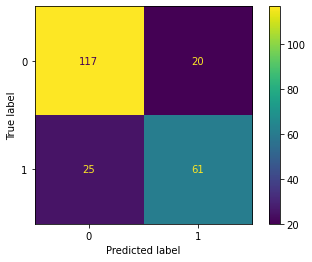

In [11]:
#Print confusion tree again
plot_confusion_matrix(clf_xgb_final,
                      X_test,
                      y_test,
                      values_format = 'd')

In [14]:
#Prtecision and recall test
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred = clf_xgb_final.predict(X_test)
print('Precision: '+ str(precision_score(y_test, y_pred)))
print('Recall: '+ str(recall_score(y_test,y_pred)))

Precision: 0.7530864197530864
Recall: 0.7093023255813954


In [15]:
#Run model on the test set for submission
yo = pd.read_csv('test.csv')

X__,Id_holder__ = clean_data('test.csv')

Survived = clf_xgb_final.predict(X__)

#Write to a csv file
Tested = {'PassengerId':Id_holder__ ,'Survived':Survived}
prediction = pd.DataFrame(data=Tested)
prediction.to_csv('submission.csv')